In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Lister les fichiers et dossiers à la racine de "MyDrive"
os.listdir('/content/drive/MyDrive/Colab Notebooks')

['E3', 'hugo']

In [ ]:
source = '/content/drive/MyDrive/Colab Notebooks/hugo/data_processed.zip'
dest   = '/content/'

!cp "$source" "$dest"

In [ ]:
!unzip -q data_processed.zip
!ls

data_processed	data_processed.zip  drive  sample_data


In [ ]:
import shutil
import random
from sklearn.model_selection import train_test_split

# Répertoires des catégories d'images
categories = ['cars', 'locomotives', 'airplanes', 'bicycles', 'trucks', 'tractors', 'boats']
data_dir = '/content/data_processed'  # Répertoire contenant les sous-dossiers de catégories

# Créer les répertoires train, validation, test
base_dir = '/content/data_processed_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Créer des sous-dossiers pour chaque catégorie dans train, validation et test
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Séparer les images en ensembles train, validation et test
for category in categories:
    category_dir = os.path.join(data_dir, category)
    all_images = os.listdir(category_dir)

    # Diviser les images en train, validation, test (70%, 20%, 10%)
    train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.333, random_state=42)  # 0.333 pour avoir 10% du total pour test

    # Déplacer les images dans les bons répertoires
    for img in train_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(train_dir, category, img))
    for img in val_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(val_dir, category, img))
    for img in test_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(test_dir, category, img))

print(f"Répertoires créés et images séparées avec succès.")

Répertoires créés et images séparées avec succès.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paramètres
img_height, img_width = 224, 224  # Taille des images (224x224x3)
batch_size = 32
num_classes = len(categories)

# Création d'un générateur d'images avec augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalisation des images (0 à 1)
    rotation_range=20,   # Rotation des images
    width_shift_range=0.2,  # Déplacement horizontal
    height_shift_range=0.2,  # Déplacement vertical
    shear_range=0.2,     # Cisaillement
    zoom_range=0.2,      # Zoom
    horizontal_flip=True,  # Retourner les images horizontalement
    fill_mode='nearest'   # Remplir les pixels manquants
)

# Flux de données d'entraînement, validation et test
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),  # Redimensionner les images
    batch_size=batch_size,
    class_mode='categorical',  # Type de label (catégorique)
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation uniquement pour les données de test
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

# Afficher le nombre d'images dans chaque ensemble
print(f'Entraînement : {train_generator.samples} images, Validation : {validation_generator.samples} images, Test : {test_generator.samples} images')

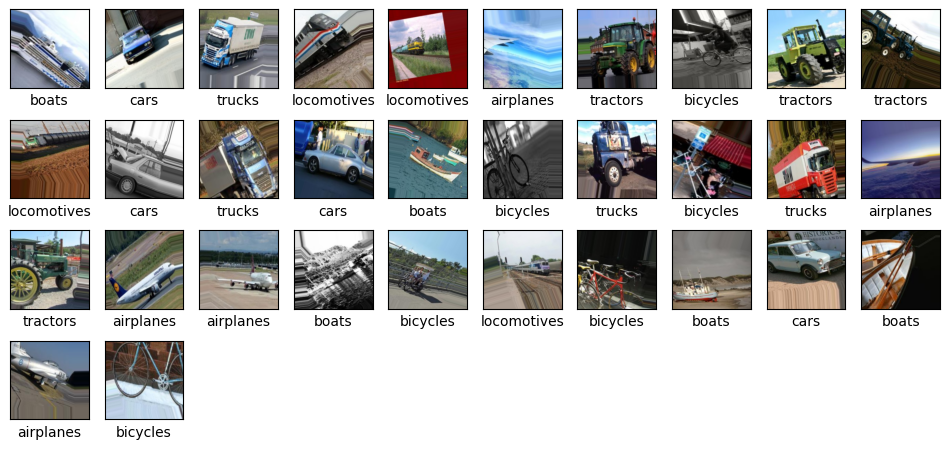

In [ ]:
import matplotlib.pyplot as plt

# Charger un batch d'images depuis le générateur
batch_size = 32
images_batch, labels_batch = next(train_generator)

# Calculer le nombre de lignes et de colonnes pour afficher les images
rows, cols = 5, 10  # 5 lignes et 10 colonnes (maximum 50 images)
plt.figure(figsize=(12, 6))
plt.subplots_adjust(top=1)

# Afficher les images
for i in range(min(batch_size, 50)):
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_batch[i])
    class_names = list(train_generator.class_indices.keys())
    plt.xlabel(class_names[labels_batch[i].argmax()])

plt.show()

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Charger le modèle MobileNetV2 pré-entraîné sur ImageNet
conv_base = MobileNetV2(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

# Réutilisation des poids des couches CONV pour conserver les features donc les layers ne se réentraine pas
for layer in conv_base.layers:
    layer.trainable = False

# # Réinitialisation des couches FC pour ajouter un classificateur adapté à notre tâche (7 classes)
x = conv_base.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(7, activation='softmax')(x) #classification en 7 classes

# Créer le modèle final
model = Model(inputs=conv_base.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning : "dégel" des couches convolutionnelles pour les réentraîner avec les nouvelles couches ajoutées
for layer in conv_base.layers:
    layer.trainable = True

# On recompile le modèle
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 194s 629ms/step - accuracy: 0.4205 - loss: 1.6395 - val_accuracy: 0.8240 - val_loss: 0.6490
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 103s 520ms/step - accuracy: 0.8803 - loss: 0.5321 - val_accuracy: 0.8988 - val_loss: 0.3333
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 141s 505ms/step - accuracy: 0.9147 - loss: 0.3053 - val_accuracy: 0.9188 - val_loss: 0.2623
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 140s 503ms/step - accuracy: 0.9401 - loss: 0.2159 - val_accuracy: 0.9294 - val_loss: 0.2168
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 101s 526ms/step - accuracy: 0.9541 - loss: 0.1597 - val_accuracy: 0.9376 - val_loss: 0.1831
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 98s 516ms/step - accuracy: 0.9570 - loss: 0.1414 - val_accuracy: 0.9447 - val_loss: 0.1664
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 142s 508ms/step - accuracy: 0.9642 - loss: 0.1199 - val_accuracy: 0.9517 - val_loss: 0.1438
Epoch 8/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 99s 521ms/step - accuracy: 0.

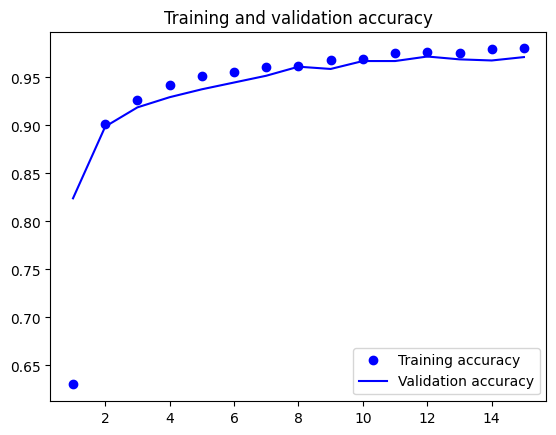

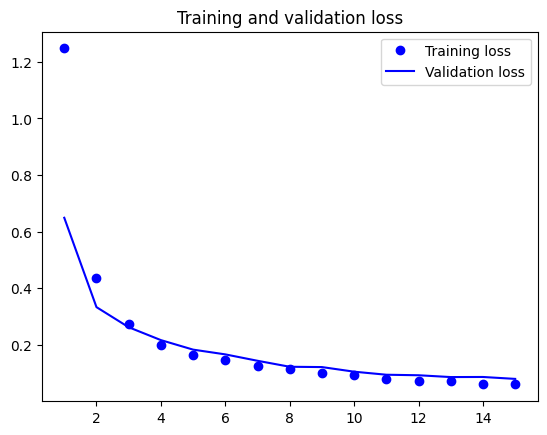

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#Évaluation du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 - 3s - 103ms/step - accuracy: 0.9871 - loss: 0.0390

Test accuracy: 0.9870740175247192
